In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras_tuner as kt

import random

import datetime
from pprint import pprint

from ts.utility import Utility
from ts.experimental import GeneralizedExtremeValueDistribution, GevEstimate, Pso
from ts.decompose import StlDecompose


# 1. Set the Python built-in random seed
random.seed(42)

# 2. Set the NumPy random seed
np.random.seed(42)

# 3. Set the TensorFlow random seed
tf.random.set_seed(42)

In [2]:
dal = pd.read_csv("datasets/rbd_data_monthly_stationary.csv")
# Step 1: Format time column as datetime format
dal['time'] = pd.to_datetime(dal['time'])
dal.set_index('time', inplace = True)
dal

,RBD
time,
1997-12-31,3.4600
1998-01-31,0.9900
1998-02-28,1.2600
1998-03-31,1.1100
1998-04-30,0.4900
...,...
2022-08-31,6.3602
2022-09-30,0.8901
2022-10-31,1.7302


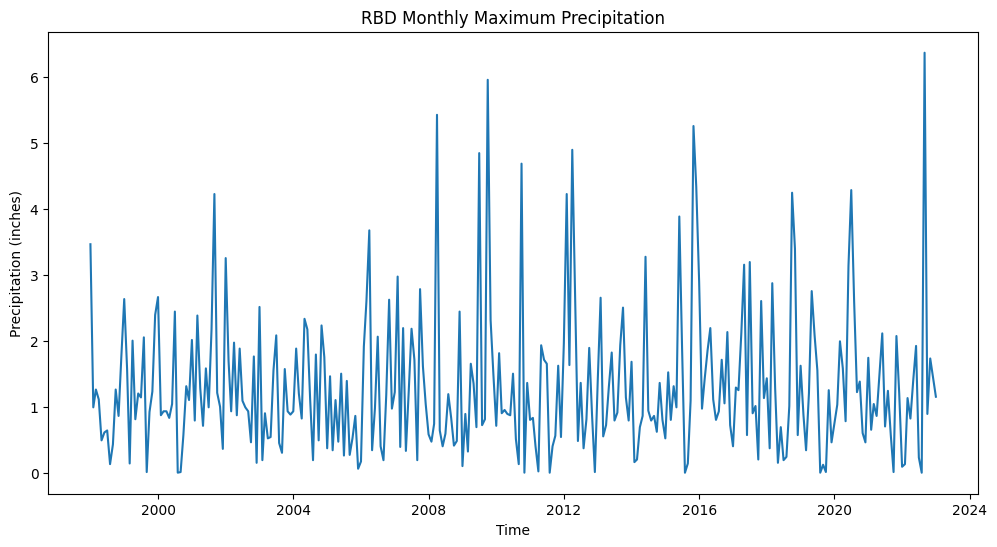

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(dal.index, dal.RBD)
plt.title('RBD Monthly Maximum Precipitation')
plt.xlabel('Time')
plt.ylabel('Precipitation (inches)')

# Save the figure with high resolution
plt.savefig("rbd_monthly_max_precip.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
month_max_series = dal.RBD
month_max_series.shape

In [ ]:
month_date_series = month_max_series.index # Probably can use the exact day insead of the last day of each month
month_date_series

In [ ]:
train_frac = 0.80
n = month_max_series.shape[0]
num_train = int(n * train_frac)
print(f'Train Size: {num_train}, Test Size: {n - num_train}')

In [ ]:
trend_series, seasonality_series, remainder_series = StlDecompose\
    .decompose(np.expand_dims(month_max_series, axis=1), 
        period=12, seasonal=101, robust=True)

assert trend_series.shape == seasonality_series.shape == remainder_series.shape

In [ ]:
trend_series_train = trend_series[:num_train]
seasonality_series_train = seasonality_series[:num_train]
remainder_series_train = remainder_series[:num_train]

In [ ]:
plt.plot(month_date_series, trend_series)
plt.title('Trend Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

plt.plot(month_date_series, seasonality_series)
plt.title('Seasonality Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

plt.plot(month_date_series, remainder_series)
plt.title('Remainder Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Trend
axs[0].plot(month_date_series, trend_series)
axs[0].set_title('Trend Series')
axs[0].set_ylabel('Value')

# Seasonality
axs[1].plot(month_date_series, seasonality_series)
axs[1].set_title('Seasonality Series')
axs[1].set_ylabel('Value')

# Remainder
axs[2].plot(month_date_series, remainder_series)
axs[2].set_title('Remainder Series')
axs[2].set_ylabel('Value')
axs[2].set_xlabel('Date')

# Tight layout and save
plt.tight_layout()
plt.savefig("decomposition_series_rbd.png", dpi=300, bbox_inches='tight')
plt.show()

1. Compare the inferred seasonality with actual data

In [ ]:
# Front Few Points
num_initial_points = 80

plt.plot(
    month_date_series[:num_initial_points],
    seasonality_series[:num_initial_points], 
    label='Inferred Seasonality'
)
plt.plot(
    month_date_series[:num_initial_points],
    month_max_series[:num_initial_points], 
    label='Actual Data'
)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Initial Few Points')
plt.show()

# Last Few Points
num_last_points = 80

plt.plot(
    month_date_series[-num_last_points:],
    seasonality_series[-num_last_points:], 
    label='Inferred Seasonality'
)
plt.plot(
    month_date_series[-num_last_points:],
    month_max_series[-num_last_points:], 
    label='Actual Data'
)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Last Few Points')
plt.show()


2. Parameter estimation of GEV fitted to remainder series

Fitting GEV parameters using PSO to remainder series

In [ ]:
params, max_log_likelihood, max_log_likelihood_vals = GevEstimate.psoMethod(
    remainder_series[:num_train],
    Pso.computeInitialPos([(-2, 2), (-2, 2), (0.1, 10)], 200),
    numIterations=200
)

shape, location, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Location Parameter: {location} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
# Save the figure with high resolution
plt.savefig("convergence_plot.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

x = np.linspace(min(remainder_series), max(remainder_series), 1000)
gev_pdf = stats.genextreme.pdf(x, -shape, loc=location, scale=scale)  # scipy uses -ξ

plt.hist(remainder_series[:num_train], bins=30, density=True, alpha=0.5, label='Remainder Series')
plt.plot(x, gev_pdf, label='GEV Fit', color='red')
plt.legend()
plt.title("GEV Fit to Remainder Series")
# Save the figure
plt.savefig("gev_fit_remainder_series.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
gev_dist = GeneralizedExtremeValueDistribution(*tuple(params))

In [ ]:
x = np.linspace(-2, 6, 10000)

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).pdf(x)
)
plt.title('PDF')
plt.show()

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).cdf(x)
)
plt.title('CDF')
plt.show()

3. Compute CDF of each data point in remainder series

In [ ]:
remainder_series_cdf = gev_dist.cdf(remainder_series)

print(f'Data Type: {remainder_series_cdf.dtype}, Data Shape: {remainder_series_cdf.shape}\n')
print('First 5 data points:')
pprint(remainder_series_cdf[:5])
print('')

print('Last 5 data points:')
pprint(remainder_series_cdf[-5:])

plt.plot(month_date_series, remainder_series_cdf)
plt.title('CDF Series')
plt.xlabel('Time')
plt.ylabel('Precipitation')
# Save the figure
plt.savefig("cdf_series.png", dpi=300, bbox_inches='tight')

plt.show()

4. Model for forecasting next day CDF

In [ ]:
input_data = []
output_data = []
lag = 50


for i in range(lag, num_train):
    input_data.append(np.squeeze(remainder_series_cdf[i - lag:i], axis=1))
    output_data.append(remainder_series_cdf[i])
    
input_data = np.array(input_data)
output_data = np.array(output_data)
    
print(f'Input Data Shape: {input_data.shape}')
print(f'Output Data Shape: {output_data.shape}')


test_input = []
test_output = []

for i in range(num_train, n):
    test_input.append(np.squeeze(remainder_series_cdf[i - lag:i], axis=1))
    test_output.append(remainder_series_cdf[i])
    
test_input = np.array(test_input)
test_output = np.array(test_output)
    
print(f'Test Input Data Shape: {test_input.shape}')
print(f'Test Output Data Shape: {test_output.shape}')

6.LSTM Model for Sequence Data

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

def make_tail_weighted_mse(alpha=2.0, power=1.0):
    def loss(y_true, y_pred):
        weights = tf.pow(tf.abs(y_true - 0.5), power) * alpha
        return tf.reduce_mean(weights * tf.square(y_true - y_pred))
    return loss




In [ ]:

def build_lstm_model(hp):
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
    from tensorflow.keras.regularizers import l2

    input_layer = Input(shape=(50, 1))

    # reg = l2(hp.Float("l2", 1e-6, 1e-3, sampling="log"))

    x = LSTM(
        units=hp.Int('lstm_units_1', 32, 128, step=32),
        return_sequences=hp.Boolean('use_second_lstm')
    )(input_layer)

    x = Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1))(x)

    if hp.Boolean('use_second_lstm'):
        x = LSTM(
            units=hp.Int('lstm_units_2', 32, 64, step=32),
            return_sequences=False
        )(x)
    else:
        x = tf.keras.layers.Flatten()(x)  # Ensure correct dimensionality if no second LSTM

    dense = Dense(
        units=hp.Int('dense_units', 16, 64, step=16),
        activation='relu'
    )(x)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=input_layer, outputs=output, name="lstm_no_attention")

    alpha = hp.Choice("alpha", [1.0, 2.0, 4.0])
    power = hp.Choice("power", [1.0, 2.0, 3.0])
    loss_fn = make_tail_weighted_mse(alpha=alpha, power=power)

    lr = hp.Choice("learning_rate", [0.01, 0.005, 0.001])
    decay_steps = hp.Choice("decay_steps", [50, 100])
    decay_rate = hp.Choice("decay_rate", [0.9, 0.95])

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        lr, decay_steps=decay_steps, decay_rate=decay_rate
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=loss_fn,
        metrics=["mae"]
    )

    return model


In [ ]:
import math
import functools
import operator

# Patch math.prod if it doesn't exist
if not hasattr(math, "prod"):
    math.prod = lambda iterable: functools.reduce(operator.mul, iterable, 1)

In [ ]:
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_results',
    project_name='lstm_attention_gev'
)

tuner.search(
    x=input_data,
    y=output_data,
    validation_data=(test_input, test_output),
    epochs=100,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)],
    verbose=1
)

# Get the best model
best_model = tuner.get_best_models(1)[0]
best_model.summary()

In [ ]:
history = best_model.fit(
    input_data, output_data,
    validation_data=(test_input, test_output),
    epochs=100
)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Test Loss', color='red')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the figure if needed
plt.savefig("training_test_loss_lstm.png", dpi=300, bbox_inches='tight')

plt.show()

5. Forecast training data

In [ ]:
remainder_train_cdf = best_model.predict(input_data)
remainder_train = gev_dist.computeQuantile(remainder_train_cdf)

plt.plot(
    month_date_series[lag: num_train], 
    output_data, 
    label='true outputs'
)
plt.plot(
    month_date_series[lag: num_train], 
    remainder_train_cdf, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('CDF Value')
plt.legend()
plt.title('Forecast Training Data')

# Save the figure if needed
plt.savefig("forecast_training_lstm.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
plt.plot(
    month_date_series[lag: num_train],
    remainder_series[lag: num_train],
    label='true outputs'
)
plt.plot(
    month_date_series[lag: num_train], 
    remainder_train, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('Remainder Series Value')
plt.legend()
plt.title('Forecasted Training Remainder Series')

# Save the figure if needed
plt.savefig("forecast_training_lstm_original_scale.png", dpi=300, bbox_inches='tight')

plt.show()

6. Forecast test data

In [ ]:
remainder_test_cdf = best_model.predict(test_input)
remainder_test = gev_dist.computeQuantile(remainder_test_cdf)

plt.plot(
    month_date_series[num_train:],
    test_output, 
    label='true outputs'
)
plt.plot(
    month_date_series[num_train:],
    remainder_test_cdf, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('CDF Series Value')
plt.legend()
plt.title('Forecast Test Data')
# Save the figure if needed
plt.savefig("forecast_test_lstm.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
plt.plot(
    month_date_series[num_train:],
    remainder_series[num_train:], 
    label='true outputs'
)
plt.plot(
    month_date_series[num_train:],
    remainder_test, 
    
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('Remainder Series Value')
plt.legend()
plt.title('Forecasted Test Remainder Series')

# Save the figure if needed
plt.savefig("forecast_test_lstm_original.png", dpi=300, bbox_inches='tight')
plt.show()

Forecasting Trend

In [ ]:
lag = 50

model_trend = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation=None)
])

model_trend.build(input_shape=(None, lag))
model_trend.compile(
    optimizer=tf.optimizers.Adam(
        tf.optimizers.schedules.ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

In [ ]:
input_data = []
output_data = []

for i in range(lag, num_train):
    input_data.append(np.squeeze(trend_series[i - lag:i], axis=1))
    output_data.append(trend_series[i])
    
input_data = np.array(input_data)
output_data = np.array(output_data)
    
print(f'Input Data Shape: {input_data.shape}')
print(f'Output Data Shape: {output_data.shape}')

In [ ]:
history = model_trend.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

In [ ]:
trend_train = model_trend.predict(input_data)

plt.plot(
    month_date_series[lag: num_train],
    output_data, 
    label='true outputs'
)
plt.plot(
    month_date_series[lag: num_train],
    trend_train, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.legend()
plt.title('Forecast Training Trend Data')


# Save the figure if needed
plt.savefig("forecast_train_lstm_trend.png", dpi=300, bbox_inches='tight')

plt.show()

7. Forecast test data

In [ ]:
test_input = []
test_output = []

for i in range(num_train, n):
    test_input.append(np.squeeze(trend_series[i - lag:i], axis=1))
    test_output.append(trend_series[i])
    
test_input = np.array(test_input)
test_output = np.array(test_output)
    
print(f'Test Input Data Shape: {test_input.shape}')
print(f'Test Output Data Shape: {test_output.shape}')

In [ ]:
trend_test = model_trend.predict(test_input)

plt.plot(
    month_date_series[num_train:], 
    test_output, 
    label='true'
)
plt.plot(
    month_date_series[num_train:], 
    trend_test, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.legend()
plt.title('Forecast Test Data')


# Save the figure if needed
plt.savefig("forecast_test_lstm_trend.png", dpi=300, bbox_inches='tight')

plt.show()

8. Forecast seasonality

In [ ]:
seasonality_train = seasonality_series[:num_train][lag:]

In [ ]:
season_values = seasonality_series[:num_train][-12:]
seasonality_test = np.zeros((n - num_train, 1))

for i in range(n - num_train):
    seasonality_test[i] = season_values[i % 12]
    
plt.plot(
    month_date_series[num_train:],
    seasonality_series[num_train:], 
    label='true'
)
plt.plot(
    month_date_series[num_train:],
    seasonality_test, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Seasonality Value')
plt.legend()
plt.title('Forecast Test Data')

# Save the figure if needed
plt.savefig("forecast_test_lstm_seasonality.png", dpi=300, bbox_inches='tight')

plt.show()

9. Forecast maximum rainfall

In [ ]:

print(remainder_train.shape, trend_train.shape, seasonality_train.shape)
print(remainder_test.shape, trend_test.shape, seasonality_test.shape)

In [ ]:
pred_train = np.maximum(remainder_train + trend_train + seasonality_train, 0)
true_train = month_max_series[:num_train][lag:]

plt.plot(
    month_date_series[lag: num_train],
    true_train, 
    label='true'
)
plt.plot(
    month_date_series[lag: num_train],
    pred_train, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Precipitation Value')
plt.legend()


# Save the figure if needed
plt.savefig("forecast_train_lstm_final.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pred_test = np.maximum(remainder_test + trend_test + seasonality_test, 0)
true_test = month_max_series[num_train:]

plt.plot(
    month_date_series[num_train:],
    true_test, 
    label='true'
)
plt.plot(
    month_date_series[num_train:],
    pred_test, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Precipitation Value')
plt.legend()

# Save the figure if needed
plt.savefig("forecast_test_lstm_final.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Step 1: Choose a high quantile threshold (e.g., 70th percentile of the true values)
threshold = np.percentile(true_test, 70)
#threshold = 2
# Step 2: Create binary labels
true_extreme = (true_test >= threshold).astype(int)
pred_extreme = (pred_test >= threshold).astype(int)

# Step 3: Compute classification metrics
precision = precision_score(true_extreme, pred_extreme)
recall = recall_score(true_extreme, pred_extreme)
f1 = f1_score(true_extreme, pred_extreme)

# Step 4: Print the results
print(f"POT Threshold (70th percentile): {threshold:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")